# Libraries

In [108]:
!pip install imagehash
!pip install imblearn

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import zipfile
import glob
import imagehash
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import random
import torch.nn as nn
# Build Inception model
from collections import namedtuple
import warnings
from torch.jit.annotations import Optional
from torch import Tensor
import requests

warnings.filterwarnings("ignore")

In [109]:
def download(class_name,url,exten='.zip'):
    response = requests.get(url)
    with open(f"{class_name}{exten}", "wb") as file:
        file.write(response.content)
    print(f"{class_name} downloaded successfully!")
    
def load_df(path, folder=""):
  df = pd.read_csv(path)
  df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: os.path.join(folder, x))
  df.rename(columns={df.columns[0]: 'imgpath'}, inplace=True)
  df.rename(columns={df.columns[1]: 'Class'}, inplace=True)
  return df

In [110]:
train_csv_path = "/kaggle/input/animal-kingdom-classification/AnimalTrainData/AnimalTrainData/train.csv"
train_images_folder = "/kaggle/input/animal-kingdom-classification/AnimalTrainData/AnimalTrainData"

In [111]:
df = load_df(train_csv_path,train_images_folder)
df.head(5)

,imgpath,Class
0,/kaggle/input/animal-kingdom-classification/An...,leopard
1,/kaggle/input/animal-kingdom-classification/An...,llama
2,/kaggle/input/animal-kingdom-classification/An...,cougar
3,/kaggle/input/animal-kingdom-classification/An...,dragonfly
4,/kaggle/input/animal-kingdom-classification/An...,leopard


# Remove duplicated images

In [112]:
def compute_hash(img_path):
    img = Image.open(img_path)
    return imagehash.average_hash(img)

def remove_duplicates(df, show_duplicates=False):
    unique_images = {}
    duplicates_info = {}
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        img_path = row.iloc[0]
        img_class = row.iloc[1]
        img_hash = compute_hash(img_path)

        if img_class not in unique_images:
            unique_images[img_class] = {'hashes': set()}
            duplicates_info[img_class] = {}

        if img_hash not in unique_images[img_class]['hashes']:
            unique_images[img_class]['hashes'].add(img_hash)
            duplicates_info[img_class][img_hash] = []
            
        duplicates_info[img_class][img_hash].append(index)

    if show_duplicates:
        plot_duplicates_by_class(df,duplicates_info)
    
    total_duplicates = 0
    for class_name, hashes in duplicates_info.items():
        indices = []
        for hsh,lst in hashes.items():
            for idx in lst[1:]:
                indices.append(idx)
            total_duplicates+=len(lst)-1
        df.drop(indices,inplace=True)
    
    df.reset_index(drop=True)
    
    # Print the number of removed duplicates and resulting DataFrame size
    print(f"Total dropped: {total_duplicates}")
    print(f"Remaining DataFrame size: {df.shape}")

def plot_duplicates_by_class(df, duplicates_info, fixed_size=(100, 100)):
    for class_name, hashes in duplicates_info.items():
        indices = []
        for hsh, lst in hashes.items():
            if len(lst) == 1:
                continue
            for idx in lst:
                indices.append(idx)
        if len(indices) == 0:
            continue

        print(f"Class: {class_name}, Duplicates Found: {len(indices)}")

        # Calculate dynamic width and fixed height
        num_images = len(indices)
        fig_width = num_images * (fixed_size[0] / 100)  # Scale width by number of images
        fig_height = 2  # Fixed height for all rows
        fig, axes = plt.subplots(1, num_images, figsize=(fig_width, fig_height))
        fig.suptitle(f"Class: {class_name}", fontsize=16)

        # Ensure `axes` is iterable
        if num_images == 1:
            axes = [axes]

        # Plot each image
        for i, idx in enumerate(indices):
            img_path = df.iloc[idx, 0]
            try:
                img = Image.open(img_path).resize(fixed_size)  # Resize to fixed size
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f"Index: {idx}", fontsize=8)
            except FileNotFoundError:
                axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[i].axis('off')

        # Remove extra axes if any
        for ax in axes[num_images:]:
            ax.remove()

        plt.tight_layout()
        plt.show()

Processing rows: 100%|██████████| 1448/1448 [00:05<00:00, 261.99it/s]


Class: llama, Duplicates Found: 2


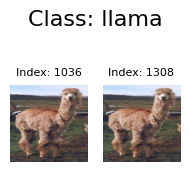

Class: crayfish, Duplicates Found: 2


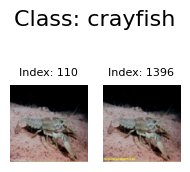

Class: octopus, Duplicates Found: 8


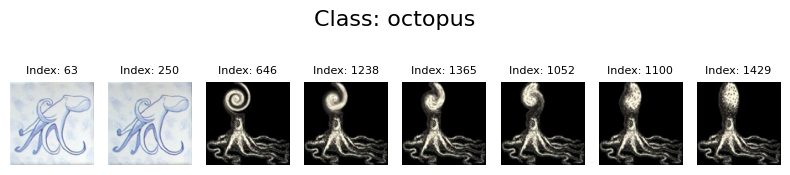

Class: rhino, Duplicates Found: 2


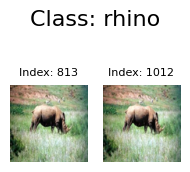

Class: pigeon, Duplicates Found: 2


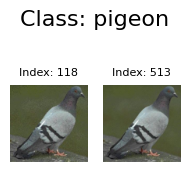

Total dropped: 9
Remaining DataFrame size: (1439, 2)


In [113]:
remove_duplicates(df, show_duplicates=True)

# Data analysis

In [114]:
def print_class_statistics(data_df):
    print("shape: ",data_df.shape)
    # Group by class and compute statistics
    class_counts = data_df['Class'].value_counts()
    print("Class Statistics:")
    print("Total Number of classes: ",len(class_counts))
    for class_name, count in class_counts.items():
        print(f"Class: {class_name}, Number of Images: {count}")

In [115]:
print_class_statistics(df)

shape:  (1439, 2)
Class Statistics:
Total Number of classes:  18
Class: leopard, Number of Images: 200
Class: cougar, Number of Images: 116
Class: flamingo, Number of Images: 112
Class: crocodile, Number of Images: 107
Class: butterfly, Number of Images: 93
Class: kangaroo, Number of Images: 86
Class: scorpion, Number of Images: 84
Class: llama, Number of Images: 77
Class: crab, Number of Images: 73
Class: crayfish, Number of Images: 71
Class: dragonfly, Number of Images: 68
Class: dolphin, Number of Images: 65
Class: elephant, Number of Images: 64
Class: rhino, Number of Images: 58
Class: beaver, Number of Images: 46
Class: lobster, Number of Images: 44
Class: pigeon, Number of Images: 44
Class: octopus, Number of Images: 31


In [116]:
unique_classes = sorted(df['Class'].unique())

# Collecting More as the data is small

## collect data

In [117]:
def download_data():
    download('leopard','https://storage.googleapis.com/cvstock-932a9-h58gl/21mmf38kfb7yvg5zr4nuyi.zip')
    download('cougar','https://storage.googleapis.com/cvstock-932a9-h58gl/e950tfxa5psb1vsibyfjz.zip')
    download('flamingo','https://storage.googleapis.com/cvstock-932a9-h58gl/4znh0s76mx8l8n5z7srfe.zip')
    download('crocodile','https://storage.googleapis.com/cvstock-932a9-h58gl/yxynnlio6rdhsaxozyptd.zip')
    download('butterfly','https://storage.googleapis.com/cvstock-932a9-h58gl/dh6ta5z6bi4de45dl3fh7.zip')
    download('kangaroo','https://storage.googleapis.com/cvstock-932a9-h58gl/onsk3gh079oayp7f742qm.zip')
    download('scorpion','https://storage.googleapis.com/cvstock-932a9-h58gl/9udtl5xrssobx54ueardb.zip')
    download('llama','https://storage.googleapis.com/cvstock-932a9-h58gl/89cklwjvdph3hhtekw8cts.zip')
    download('crab','https://storage.googleapis.com/cvstock-932a9-h58gl/x9j3jivcibkk01mpd9g91g.zip')
    download('crayfish','https://storage.googleapis.com/cvstock-932a9-h58gl/ytgx4l3s0cnqsfbdqa9a4.zip')
    download('dragonfly','https://storage.googleapis.com/cvstock-932a9-h58gl/3izu0315vhp0gegjyiya.zip')
    download('dolphin','https://storage.googleapis.com/cvstock-932a9-h58gl/ercu1fv9uive4x2l8s7of7.zip')
    download('elephant','https://storage.googleapis.com/cvstock-932a9-h58gl/snmzodgxyadmfnfe4kx729.zip')
    download('rhino1','https://storage.googleapis.com/cvstock-932a9-h58gl/0anitljl1keh7gdy30ql7h3.zip')
    download('rhino2','https://storage.googleapis.com/cvstock-932a9-h58gl/asqdztgkeqky6uhc3m32.zip')
    download('beaver','https://storage.googleapis.com/cvstock-932a9-h58gl/6jb6ukqbdjwhc3nx1ifuym.zip')
    download('pigeon1','https://storage.googleapis.com/cvstock-932a9-h58gl/j7by5kxbrffbqakeae00ji.zip')
    download('pigeon2','https://storage.googleapis.com/cvstock-932a9-h58gl/bgw346zgp58z5m571uf57d.zip')
    download('pigeon3','https://storage.googleapis.com/cvstock-932a9-h58gl/z50f02we7bk62kx5e59u28.zip')
    download('pigeon4','https://storage.googleapis.com/cvstock-932a9-h58gl/wltmk2d6h4636oz06fl2p.zip')
    download('lobster','https://storage.googleapis.com/cvstock-932a9-h58gl/eh8ruftzwq67emzn5jw0mt.zip')
    download('octopus','https://storage.googleapis.com/cvstock-932a9-h58gl/39c2yat3gkc9qqmy3swr6a.zip')
download_data()

leopard downloaded successfully!
cougar downloaded successfully!
flamingo downloaded successfully!
crocodile downloaded successfully!
butterfly downloaded successfully!
kangaroo downloaded successfully!
scorpion downloaded successfully!
llama downloaded successfully!
crab downloaded successfully!
crayfish downloaded successfully!
dragonfly downloaded successfully!
dolphin downloaded successfully!
elephant downloaded successfully!
rhino1 downloaded successfully!
rhino2 downloaded successfully!
beaver downloaded successfully!
pigeon1 downloaded successfully!
pigeon2 downloaded successfully!
pigeon3 downloaded successfully!
pigeon4 downloaded successfully!
lobster downloaded successfully!
octopus downloaded successfully!


## extract the collected Data

In [118]:
def extract_data():
    big_dataset_dir = "/kaggle/working/Animals-Dataset"
    # shutil.rmtree(big_dataset_dir)
    os.makedirs(big_dataset_dir, exist_ok=True)
    images_dir = os.path.join(big_dataset_dir,'images')
    os.makedirs(images_dir, exist_ok=True)
    # Prepare a list to hold image paths and labels for the CSV
    image_ids = []
    classes = []
    for class_name in unique_classes:
        # Iterate through files in the directory
        id = 0
        for filename in os.listdir('/kaggle/working/'):
            if filename.startswith(class_name) and filename.endswith('.zip'):
                zip_file_path = filename
                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall('/kaggle/working/')  # Extract the zip to the working directory
                jpg_files = glob.glob(os.path.join('images.cv*', '**', '*.jpg'), recursive=True)
                # Move all found jpg files directly into Big Dataset folder
                for img_path in jpg_files:
                    dest_img_path = os.path.join(images_dir, f'{class_name}_{id}.jpg')
                    shutil.move(img_path, dest_img_path)
                    image_ids.append(f'{class_name}_{id}.jpg')
                    classes.append(class_name)
                    id+=1
                extracted_folders = glob.glob('images.cv_*')
                for folder in extracted_folders:
                    shutil.rmtree(folder, ignore_errors=True)
                os.remove(filename)
    csv_data = pd.DataFrame({
        'ImageID': image_ids,
        'Class': classes
    })
    csv_file_path = os.path.join(big_dataset_dir, 'image_labels.csv')
    print(csv_file_path)
    csv_data.to_csv(csv_file_path, index=False)
    print("Process completed successfully!")
extract_data()

/kaggle/working/Animals-Dataset/image_labels.csv
Process completed successfully!


In [119]:
train_csv_path2 = '/kaggle/working/Animals-Dataset/image_labels.csv'
train_images_folder2 = '/kaggle/working/Animals-Dataset/images'
df2 = load_df(train_csv_path2,train_images_folder2)
df2.head(5)

,imgpath,Class
0,/kaggle/working/Animals-Dataset/images/beaver_...,beaver
1,/kaggle/working/Animals-Dataset/images/beaver_...,beaver
2,/kaggle/working/Animals-Dataset/images/beaver_...,beaver
3,/kaggle/working/Animals-Dataset/images/beaver_...,beaver
4,/kaggle/working/Animals-Dataset/images/beaver_...,beaver


## analysis & cleaning the collected data

In [120]:
df2.duplicated().sum()

0

In [121]:
print_class_statistics(df2)

shape:  (27841, 2)
Class Statistics:
Total Number of classes:  18
Class: butterfly, Number of Images: 7784
Class: flamingo, Number of Images: 2068
Class: scorpion, Number of Images: 1933
Class: dragonfly, Number of Images: 1419
Class: leopard, Number of Images: 1401
Class: llama, Number of Images: 1373
Class: crayfish, Number of Images: 1365
Class: beaver, Number of Images: 1345
Class: cougar, Number of Images: 1300
Class: crab, Number of Images: 1228
Class: elephant, Number of Images: 1056
Class: rhino, Number of Images: 1033
Class: crocodile, Number of Images: 934
Class: kangaroo, Number of Images: 852
Class: octopus, Number of Images: 813
Class: lobster, Number of Images: 746
Class: dolphin, Number of Images: 680
Class: pigeon, Number of Images: 511


In [122]:
def remove_non_Existing_images(df):
    # Iterate through the DataFrame and remove rows where the image path is invalid
    df = df[df['imgpath'].apply(lambda x: os.path.exists(x) if x is not None else False)]
    # Optionally, reset the index after removing rows
    df.reset_index(drop=True, inplace=True)
    return df

In [123]:
remove_non_Existing_images(df2)
print(df2.shape)

(27841, 2)


## merge the data

In [124]:
def add_image_paths_to_df(df, base_path):
    for folder_name in os.listdir(base_path):
        class_name = folder_name.split()[0]  # Assuming class name is the first word in the folder name
        folder_path = os.path.join(base_path, folder_name)
        # Process only folders that match any of the provided class names
        ok = False
        for class_i in unique_classes:
            if class_name.lower().startswith(class_i.lower()):
                class_name=class_i.lower()
                ok = True
                break
        if ok:
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                df = pd.concat([df, pd.DataFrame({'imgpath': [file_path], 'Class': [class_name]})], ignore_index=True)
    return df

In [125]:
final_df = pd.concat([df, df2], ignore_index=True)
before = final_df.shape[0]
final_df = add_image_paths_to_df(final_df, '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals')
final_df = add_image_paths_to_df(final_df, '/kaggle/input/sea-animals-image-dataste')
print(f"Added {final_df.shape[0]-before}")

Added 3062


In [126]:
num_duplicates = final_df.duplicated().sum()
print(num_duplicates)

0


In [127]:
remove_duplicates(final_df)

Processing rows: 100%|██████████| 32342/32342 [02:25<00:00, 222.12it/s]

Total dropped: 1685
Remaining DataFrame size: (30657, 2)


# split the data

In [128]:
# Split to train,val and test
df = final_df

# Apply the previous split logic
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, stratify=df['Class'], random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, stratify=temp_df['Class'], random_state=42)

# Reset indices for clean DataFrames
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print statistics
print("----------Train-------------")
print_class_statistics(train_df)
print("--------Validation----------")
print_class_statistics(valid_df)
print("----------Test--------------")
print_class_statistics(test_df)

----------Train-------------
shape:  (21459, 2)
Class Statistics:
Total Number of classes:  18
Class: butterfly, Number of Images: 5447
Class: flamingo, Number of Images: 1473
Class: scorpion, Number of Images: 1351
Class: crab, Number of Images: 1214
Class: leopard, Number of Images: 1120
Class: dolphin, Number of Images: 1020
Class: dragonfly, Number of Images: 1006
Class: cougar, Number of Images: 990
Class: crayfish, Number of Images: 966
Class: octopus, Number of Images: 965
Class: llama, Number of Images: 964
Class: beaver, Number of Images: 945
Class: lobster, Number of Images: 869
Class: elephant, Number of Images: 747
Class: rhino, Number of Images: 720
Class: crocodile, Number of Images: 701
Class: kangaroo, Number of Images: 603
Class: pigeon, Number of Images: 358
--------Validation----------
shape:  (6438, 2)
Class Statistics:
Total Number of classes:  18
Class: butterfly, Number of Images: 1634
Class: flamingo, Number of Images: 442
Class: scorpion, Number of Images: 405


# visualization

In [129]:
def visualize(df):
    plt.figure(figsize=(15,12))
    for i, row in df.sample(n=16).reset_index().iterrows():
        plt.subplot(4,4,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["Class"])
        plt.axis('off')
    plt.show()

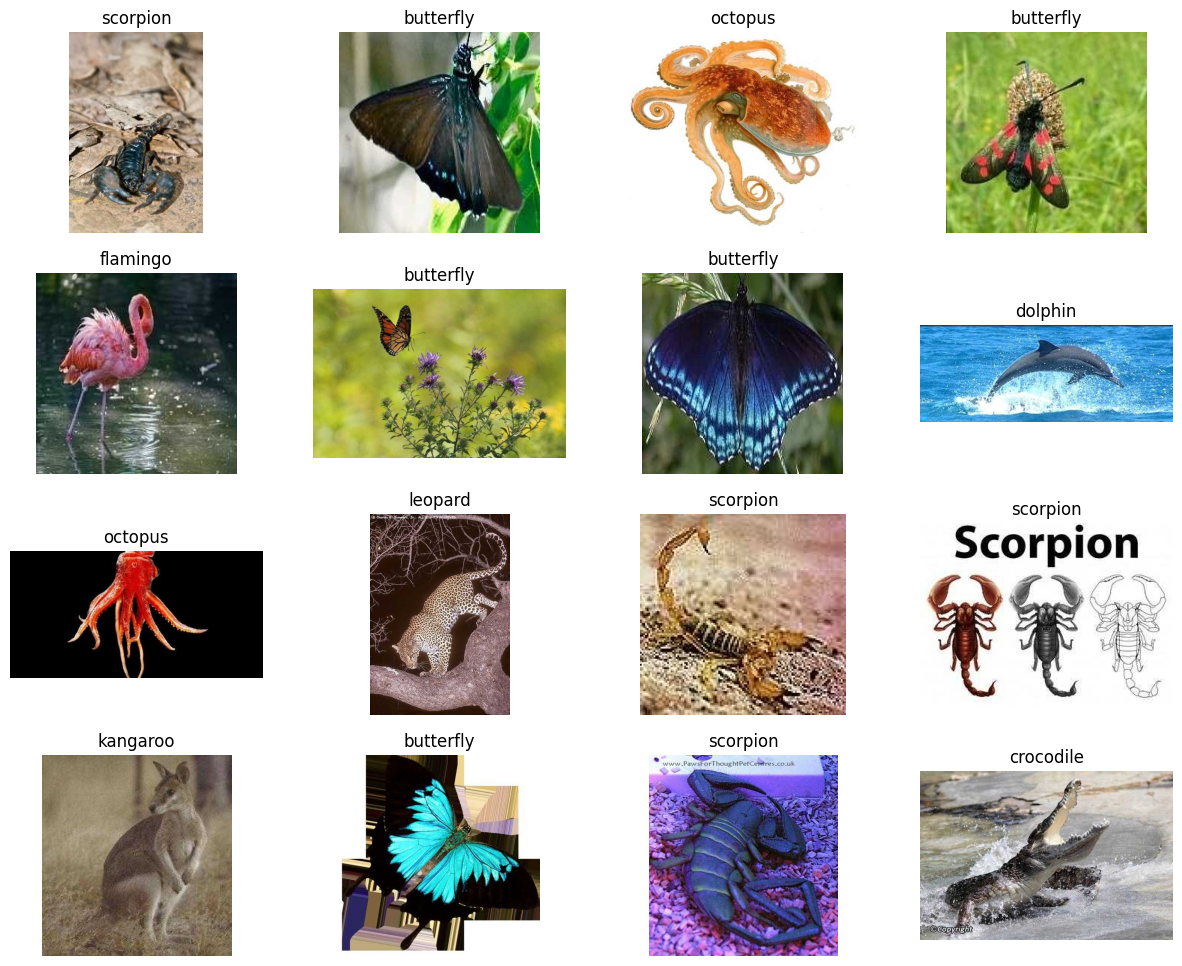

In [130]:
visualize(train_df)

# Encoding

In [131]:
unique_classes = sorted(final_df['Class'].unique())
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}
print("Class Dictionary:", class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}

Class Dictionary: {'beaver': 0, 'butterfly': 1, 'cougar': 2, 'crab': 3, 'crayfish': 4, 'crocodile': 5, 'dolphin': 6, 'dragonfly': 7, 'elephant': 8, 'flamingo': 9, 'kangaroo': 10, 'leopard': 11, 'llama': 12, 'lobster': 13, 'octopus': 14, 'pigeon': 15, 'rhino': 16, 'scorpion': 17}


# save preprocessing

In [133]:
def save_data_together(final_df, data_folder):
    # Ensure the folder exists
    if os.path.exists(data_folder):
        shutil.rmtree(data_folder)
    os.makedirs(data_folder, exist_ok=True)
    classes_folder = os.path.join(data_folder, 'classes')
    os.makedirs(classes_folder)

    # Prepare CSV file path
    csv_file_path = os.path.join(data_folder, 'images_metadata.csv')
    # Initialize an empty DataFrame for the CSV file
    csv_data = []
    
    # Group by 'Class' and process images
    grouped = final_df.groupby('Class')
    for class_name, group in grouped:
        class_folder = os.path.join(classes_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        idx = 0
        for _, row in group.iterrows():
            img_path = row['imgpath']
            # Create a new image name
            new_name = f"{class_name}_{idx}.jpg"
            new_img_path = os.path.join(class_folder, new_name)
    
            # copy the image
            shutil.copy(img_path, new_img_path)
    
            # Append to CSV data
            csv_data.append({'imgpath': new_img_path, 'Class': class_to_idx[class_name]})
            idx+=1
    # Save the updated CSV
    pd.DataFrame(csv_data).to_csv(csv_file_path, index=False)
    
all_data_folder = 'all_data'
if os.path.exists(all_data_folder):
    shutil.rmtree(all_data_folder)
os.makedirs(all_data_folder)

save_data_together(train_df, 'all_data/train')
save_data_together(valid_df, 'all_data/val')
save_data_together(test_df, 'all_data/test')
shutil.rmtree('Animals-Dataset')

# load preprocessing

In [134]:
train_df = pd.read_csv('/kaggle/working/all_data/train/images_metadata.csv')
val_df = pd.read_csv('/kaggle/working/all_data/val/images_metadata.csv')
test_df = pd.read_csv('/kaggle/working/all_data/test/images_metadata.csv')
train_df.head()

,imgpath,Class
0,all_data/train/classes/beaver/beaver_0.jpg,0
1,all_data/train/classes/beaver/beaver_1.jpg,0
2,all_data/train/classes/beaver/beaver_2.jpg,0
3,all_data/train/classes/beaver/beaver_3.jpg,0
4,all_data/train/classes/beaver/beaver_4.jpg,0


In [135]:
unique_classes = sorted(os.listdir('/kaggle/working/all_data/train/classes'))
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}
print("Class Dictionary:", class_to_idx)
idx_to_class = {v: k for k, v in class_to_idx.items()}

Class Dictionary: {'beaver': 0, 'butterfly': 1, 'cougar': 2, 'crab': 3, 'crayfish': 4, 'crocodile': 5, 'dolphin': 6, 'dragonfly': 7, 'elephant': 8, 'flamingo': 9, 'kangaroo': 10, 'leopard': 11, 'llama': 12, 'lobster': 13, 'octopus': 14, 'pigeon': 15, 'rhino': 16, 'scorpion': 17}
